# Sentiment Analysis of Movie Reviews pt.1 -- Basics

When you have a large amount of movie reviews, how can you know whether they are complments or criticisms? Since the amount of dataset is large, you cannot annotate them one by one, but need to use natural language processing tools to classify the sentiment of the text. Especially in Python, powerful packages like nltk and scikit-learn can help us do the text classification. In this project, I made a sentiment analysis of movie reviews from the dataset of [reviews on imdb](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) from the UCI Machine Learning Repository's Sentiment Labelled Sentences Data Set.

## Text Preprocessing
In this dataset, there are 1000 movie reviews, including 500 positive (compliments) and 500 negative (criticisms). For example, *'A very, very, very slow-moving, aimless movie about a distressed, drifting young man.'* is marked as a negative review. 

However, in the raw text, we can see many words do not contain important semantics. The numbers and punctuations appear a lot in our raw text but has do not express positive or negative sentiment. Therefore, we need to strip numbers and punctuations.

To further clean the data, we need to stem the words, so that words with different inflections can be counted as same tokens, because they convey the same semantics. e.g. 'distress' and 'distressed' will both be stemmed as 'distress'.

After text preprocessing, we have 2 list of data. 'labels' is the list of targets of our classification. 'preprocessed' is the features-to-be of classification. For sentences in 'preprocessed', we translate the raw text into completely unreadable text. For example, *'A very, very, very slow-moving, aimless movie about a distressed, drifting young man.'* is to preprocessed as *'a veri veri veri slow move aimless movi about a distress drift young man'*

You may wonder that: we translate the raw text into these unreadable text because we want each token to convey important semantics. Then why not strip the stopwords because they do not convey important semantics but are very frequent, such as 'a' and 'about'? In the next feature extraction section, we are going to use TF-IDF to take care of those stop words

## Feature Extraction
After text preprocessing, we are going to extract the features from our cleaned data. We are going to use TF-IDF vectorizer as our word embedding to vectorize and normalize the text. 

TF-IDF stands for term frequency-inverse document frequency. It evaluates the importance of a token to a document in a corpus. TF-IDF makes the data our model because it normalizes the term frequency, or simply the word count. It also reduces the noise of stop words.
    
We are going to take a variant of TF-IDF in this case. The formula for regular TF-IDF is [here](http://www.tfidf.com/). Unlike the orgininal TF-IDF, we change to use sublinear_tf, replacing TF with WF = 1 + log(TF). This variant addresses the problem that ["twenty occurrences of a term in a document do not truly carry twenty times the significance of a single occurrence."](https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html) For example, in the example of our first review *'A very, very, very slow-moving, aimless movie about a distressed, drifting young man.'* 'very' appeared three times. Therefore, for our dataset, we need to apply Sublinear TF scaling. It drastically improves the accuracy of our models' prediction later.

After feature extraction, we have Tf-IDF-weighted document-term matrix stored in Compressed Sparse Row format. Each target is the sentiment of this sentence. '1' means positive and '0' means negative. But to make the data fit our model, we need to split our data into features and targets. Scikit-learn's train_test_split to randomly shuffle the data and split them into training set and testing set. In this specific case, I will use 1/5 of the whole dataset of testing set and the rest 4/5 as training set. Here is the code for the whole preprocessing process:

In [1]:
from nltk.stem import PorterStemmer    # stem the words
from nltk.tokenize import word_tokenize # tokenize the sentences into tokens
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer # vectorize the texts
from sklearn.model_selection import train_test_split # split the testing and training sets

def preprocess(path):
    '''generate cleaned dataset
    
    Args:
        path(string): the path of the file of testing data

    Returns:
        X_train (list): the list of features of training data
        X_test (list): the list of features of test data
        y_train (list): the list of targets of training data ('1' or '0')
        y_test (list): the list of targets of training data ('1' or '0')
    '''
    
    # text preprocessing: iterate through the original file and 
    with open(path, encoding='utf-8') as file:
        # record all words and its label
        labels = []
        preprocessed = []
        for line in file:
            # get sentence and label
            sentence, label = line.strip('\n').split('\t')
            labels.append(int(label))
            
            # remove punctuation and numbers
            for ch in punctuation+'0123456789':
                sentence = sentence.replace(ch,' ')
            # tokenize the words and stem them
            words = []
            for w in word_tokenize(sentence):
                words.append(PorterStemmer().stem(w))
            preprocessed.append(' '.join(words))
    
    # vectorize the texts
    vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True)
    X = vectorizer.fit_transform(preprocessed)
    # split the testing and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess('imdb_labelled.txt')

## Modeling
We can train the models with the training set, let the models to classify the testing set, and rate the models' performances by checking its accuracy score and time consumption. Here is the code for the classification:

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
from time import time

def classify(clf, todense=False):
    '''to classify the data using machine learning models
    
    Args:
        clf: the model chosen to analyze the data
        todense(bool): whether to make the sparse matrix dense
        
    '''
    global X_train, X_test, y_train, y_test
    t = time()
    if todense:
        clf.fit(X_train.todense(), y_train)
        y_pred = clf.predict(X_test.todense())
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
    print(f'Time cost of {str(clf)}: {round(time()-t,2)}s\nThe accuracy of {str(clf)}: {accuracy_score(y_test,y_pred)}\n')

Because the target is categorical and dichotomous, the features do not have assumed distribution, the models we can use for text classification are Logistics Regression, Stochastic Gradient Descent Classifier (SGDClassifier), Support Vector Classifier (SVC) and Neural Network (MLPClassifier). Because our feature data is sparse, SVC and SGD are useful. Among 3 types of Naive Bayes Classifiers (Bernoulli, Multinomial and Gaussian), we need to choose Multinomial, because the features are normalized by TF-IDF. The features do not fit Gaussian nor Bernoulli distribution.

I will examine the performance of each selected model below. In this part, I will not tune the parameters for each model, but will do it in future.

We can technically use Linear Driscriminant Analysis too. However, it is computationally expensive to calculate sparse matrices like our feature data. The accuracy of this model is also low. Therefore, we will not consider LDA this time. Here is the performance of LDA

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classify(LinearDiscriminantAnalysis(),todense=True)

Time cost of LinearDiscriminantAnalysis(): 0.79s
The accuracy of LinearDiscriminantAnalysis(): 0.71



Here are the performances of the selected models:

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
for model in [LogisticRegression(), MultinomialNB(), SVC(), SGDClassifier(), MLPClassifier()]:
    classify(model)

Time cost of LogisticRegression(): 0.03s
The accuracy of LogisticRegression(): 0.825

Time cost of MultinomialNB(): 0.0s
The accuracy of MultinomialNB(): 0.825

Time cost of SVC(): 0.09s
The accuracy of SVC(): 0.835

Time cost of SGDClassifier(): 0.0s
The accuracy of SGDClassifier(): 0.82

Time cost of MLPClassifier(): 3.47s
The accuracy of MLPClassifier(): 0.81



## Ensemble Learning
While we want to improve the accuracy of our models' prediction, we also want overfitting avoided, so that we can use the models to predict other datasets. Building an ensemble method is the solution to this problem. For each review, we are going to let every selected model vote for its own prediction, and take the mode of all votes to generate an ensemble prediction. The selected models are Logistic Regression, MultinomialNB, SVC and SGD. Because Neural Networks need complicated tuning and are time-consuming, I will not include MLPClassifier into this ensembel Learning. From the accuracy score and the confusion matrix below, we can see that, though the time cost increased, the performance of the ensemble model is satisfactory.

Time cost: 0.12s
Accuracy: 0.83



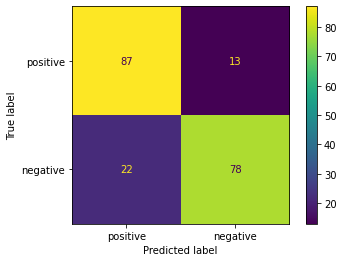

In [5]:
from statistics import mode
def ensemble(models):
    '''to ensemble the models and classify the data based on each model's vote
    
    Args:
        models: the list of models chosen to analyze the data
        
    '''
    global X_train, X_test, y_train, y_test
    t = time()
    # iterate through all the models and collect all their predictions
    y_preds = []
    for clf in models:
        clf.fit(X_train, y_train)
        y_preds.append(clf.predict(X_test))
    
    # Count their votes and get the mode of each prediction as the decision
    y_pred = []
    for i in range(len(y_preds[0])):
        y_pred.append(mode([y[i] for y in y_preds]))
    print(f'Time cost: {round(time()-t,2)}s\nAccuracy: {accuracy_score(y_test,y_pred)}\n')
    plot_confusion_matrix(clf, X_test, y_test, values_format = 'd',display_labels=['positive','negative'])

ensemble([LogisticRegression(),MultinomialNB(),SVC(),SGDClassifier()])